In [56]:
from scipy.stats import ttest_1samp, norm, t, kstest, shapiro, mannwhitneyu
import statsmodels.api as sm 
import numpy  as np

import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')


In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

Загрузим данные

In [86]:
df = pd.read_csv("AB_Test_Results_homework.csv", sep=',', encoding='windows-1251')
df.sort_values('USER_ID')

,USER_ID,VARIANT_NAME,REVENUE
2406,2,control,"0,00"
3479,2,control,"0,00"
7076,2,control,"0,00"
7409,3,variant,"0,00"
4145,3,variant,"0,00"
...,...,...,...
2998,9996,control,"0,00"
1064,9998,control,"0,00"
8970,10000,variant,"0,00"
8921,10000,control,"0,00"


Проверим информацию по таблице: Пустых значений нет
Хотела поменять тип столбца Revenue на flout, но из за ковычек не меняется

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   USER_ID       10000 non-null  int64 
 1   VARIANT_NAME  10000 non-null  object
 2   REVENUE       10000 non-null  object
dtypes: int64(1), object(2)
memory usage: 234.5+ KB


In [87]:
# преобразовала столбец REVENUE из object в float
df = pd.read_csv("AB_Test_Results_homework.csv")
df["REVENUE"] = df["REVENUE"].str.replace(",", ".")
df['REVENUE'] = df['REVENUE'].astype(float)

In [48]:
df.shape

(10000, 3)

In [65]:
# посмотрели разделение по группам
df.VARIANT_NAME.value_counts()

VARIANT_NAME
variant    5016
control    4984
Name: count, dtype: int64

In [92]:
# сделала как в лекции. Новый дата фрейм где смотрим есть ли юзеры в разных группах одновременно
v = df.\
    groupby('USER_ID', as_index=False).\
    agg({'VARIANT_NAME': pd.Series.nunique})

In [82]:
v.head(10)

,USER_ID,VARIANT_NAME
0,2,1
1,3,2
2,4,1
3,5,1
4,6,1
5,9,1
6,10,2
7,11,1
8,12,1
9,13,1


In [102]:
#  далее если есть такие, мы их удалили и сделали новый дата фрейм, уже измененный 
one_types = v.query('VARIANT_NAME > 1')
df_new = df[~df.USER_ID.isin(one_types.USER_ID)].sort_values('USER_ID')
df_new.shape

(6070, 3)

In [103]:
df_new[df_new['VARIANT_NAME']=='control'].describe()

,USER_ID,REVENUE
count,3026.000000,3026.000000
mean,4990.392928,0.155506
std,2919.665981,3.708620
min,2.000000,0.000000
25%,2457.750000,0.000000
50%,4949.500000,0.000000
75%,7603.750000,0.000000
max,9998.000000,196.010000


In [104]:
# посмотрели две таблицы по отдельности, предврительный вывод, что различия в столбце Revenue в mean, std и max
df_new[df_new['VARIANT_NAME']=='variant'].describe()

,USER_ID,REVENUE
count,3044.000000,3044.000000
mean,4976.975033,0.058909
std,2876.744694,0.760344
min,4.000000,0.000000
25%,2487.250000,0.000000
50%,4950.000000,0.000000
75%,7376.500000,0.000000
max,9995.000000,23.040000


In [119]:
control_group = df_new['VARIANT_NAME']=='control'
test_group = df_new['VARIANT_NAME']=='variant'

In [120]:
# смотрим сколько юзеров в каждой группе после изменений
df_new.VARIANT_NAME.value_counts()

VARIANT_NAME
variant    3044
control    3026
Name: count, dtype: int64

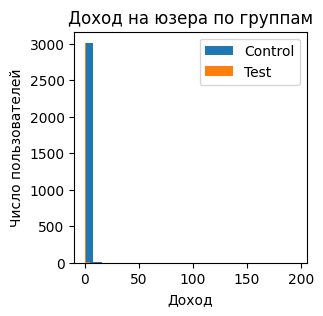

In [147]:
# control.REVENUE.hist(bins = 25, alpha =0.7, label='Control')
# test.REVENUE.hist(bins = 25, alpha =0.7, label='Test')
# plt.title('Доход на юзера по группам')
# plt.xlabel('Доход')
# plt.ylabel('Число пользователей')
# plt.legend()


plt.figure(figsize=(3, 3))
control_group = df_new['REVENUE'][df_new['VARIANT_NAME'] == 'control']
test_group = df_new['REVENUE'][df_new['VARIANT_NAME'] == 'variant']


plt.hist(control_group, bins=25,  label='Control')
plt.hist(test_group, bins=25, label='Test')
plt.title('Доход на юзера по группам')
plt.xlabel('Доход')
plt.ylabel('Число пользователей')
plt.legend()

plt.show()

# видно, что нормального распределения нет

In [133]:
# распределение не является нормальным
print(kstest(control_group, "norm"))
print(kstest(test_group, "norm"))

KstestResult(statistic=0.5, pvalue=0.0, statistic_location=0.0, statistic_sign=-1)
KstestResult(statistic=0.5, pvalue=0.0, statistic_location=0.0, statistic_sign=-1)


In [136]:
# распределение не является нормальным
print(shapiro(control_group))
print(shapiro(test_group))

ShapiroResult(statistic=0.017641663551330566, pvalue=0.0)
ShapiroResult(statistic=0.051010727882385254, pvalue=0.0)


In [138]:
import scipy.stats as stats

In [139]:
# по ttest_ind статистически значимых различий не выявлено, так как
# pvalue > alpha
stats.ttest_ind(control_group, test_group, equal_var = False)

TtestResult(statistic=1.403762252371675, pvalue=0.1604844017690842, df=3277.3923073352767)

In [140]:
# по не парарметрическому тесту Манна Уитни, статистически значимых различий не выявлено, так как
# pvalue > alpha
stats.mannwhitneyu(control_group, test_group)

MannwhitneyuResult(statistic=4622832.0, pvalue=0.2444173738649208)

In [148]:
# проведем еще тест на мощность самого теста, что бы проверить, правда ли нет различий или тест слабый
m_1 = control_group.mean()
m_2 = test_group.mean()

std_1 = control_group.std()
std_2 = test_group.std()


In [152]:
s = np.sqrt((std_1**2 + std_2**2)/2)
s

2.6769369641263743

In [154]:
d = float((m_1 - m_2)/s)
d
# мощность теста очень низкая

0.03608463308730934